In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os

In [7]:
image_folder_path = "/content/drive/MyDrive/iitisoc_ps1/sar_dataset/Train_Val_Oil_Spill_images/Oil"

image_paths = []
for item_name in os.listdir(image_folder_path):
    full_path0 = os.path.join(image_folder_path, item_name)

    image_paths.append(full_path0)


mask_folder_path = "/content/drive/MyDrive/iitisoc_ps1/sar_dataset/Train_Val_Oil_Spill_mask/Mask_oil"
mask_paths = []
for item_name in os.listdir(mask_folder_path):
    full_path1 = os.path.join(mask_folder_path, item_name)
    mask_paths.append(full_path1)

image_basenames = set(os.path.basename(p) for p in image_paths)
mask_basenames  = set(os.path.basename(p) for p in mask_paths)

common_basenames = sorted(image_basenames & mask_basenames)

image_paths = [os.path.join(image_folder_path, f) for f in common_basenames]
mask_paths =  [os.path.join(mask_folder_path, f) for f in common_basenames]



image_paths = image_paths[:50]
mask_paths =  mask_paths[:50]


In [11]:
pip install scikit-learn

In [12]:
pip install rasterio


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter


In [9]:
#Filtering of image
def kuan_filter(img, size):


    local_mean = uniform_filter(img, size)
    local_mean_sq = uniform_filter(img**2, size)
    local_var = local_mean_sq - local_mean**2

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        cu = local_var / (local_var + local_mean**2)
        cu = np.nan_to_num(cu)  # replaces NaN and inf with 0

    # Apply the Kuan formula
    filtered_img = local_mean + cu * (img - local_mean)
    return filtered_img

In [10]:
# Split data at image level
train_images, test_images, train_masks, test_masks = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=42
)

In [11]:
def load_and_flatten(full_path0, full_path1):
    try:
        with rasterio.open(full_path0) as src:
            image0 = src.read(1)
            image1 = src.read(2)

        # Apply Kuan filter to both bands
        image0 = kuan_filter(image0, size=7)
        image1 = kuan_filter(image1, size=7)
        image0[image0 == 0] = np.mean(image0[image0 != 0])
        image1[image1 == 0] = np.mean(image1[image1 != 0])

        raw0 = image0.flatten()
        raw1 = image1.flatten()
        X = np.stack((raw0, raw1), axis=1)

        with rasterio.open(full_path1) as src:
            mask = src.read()
        Y = mask.flatten()

        return X, Y

    except Exception as e:
        print(f"Skipping file due to error: {full_path0}")
        print(f"Error: {e}")
        return None, None


# Prepare training data
X_train_all = []
Y_train_all = []

for img_path, mask_path in zip(train_images, train_masks):
    X, Y = load_and_flatten(img_path, mask_path)
    if X is not None and Y is not None:
        X_train_all.append(X)
        Y_train_all.append(Y)

# Stack all into final training arrays
X_train = np.vstack(X_train_all)
Y_train = np.hstack(Y_train_all)


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [12]:
# Initialize and train model
model = LogisticRegression(class_weight = {0: 1.0, 1: 20.0},max_iter=1000)
model.fit(X_train, Y_train)


LogisticRegression(class_weight={0: 1.0, 1: 20.0}, max_iter=1000)

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00013.tif

Results for: 00013.tif


              precision    recall  f1-score   support

  Background       0.99      0.98      0.98   4025104
   Oil Spill       0.62      0.65      0.64    169200

    accuracy                           0.97   4194304
   macro avg       0.80      0.82      0.81   4194304
weighted avg       0.97      0.97      0.97   4194304



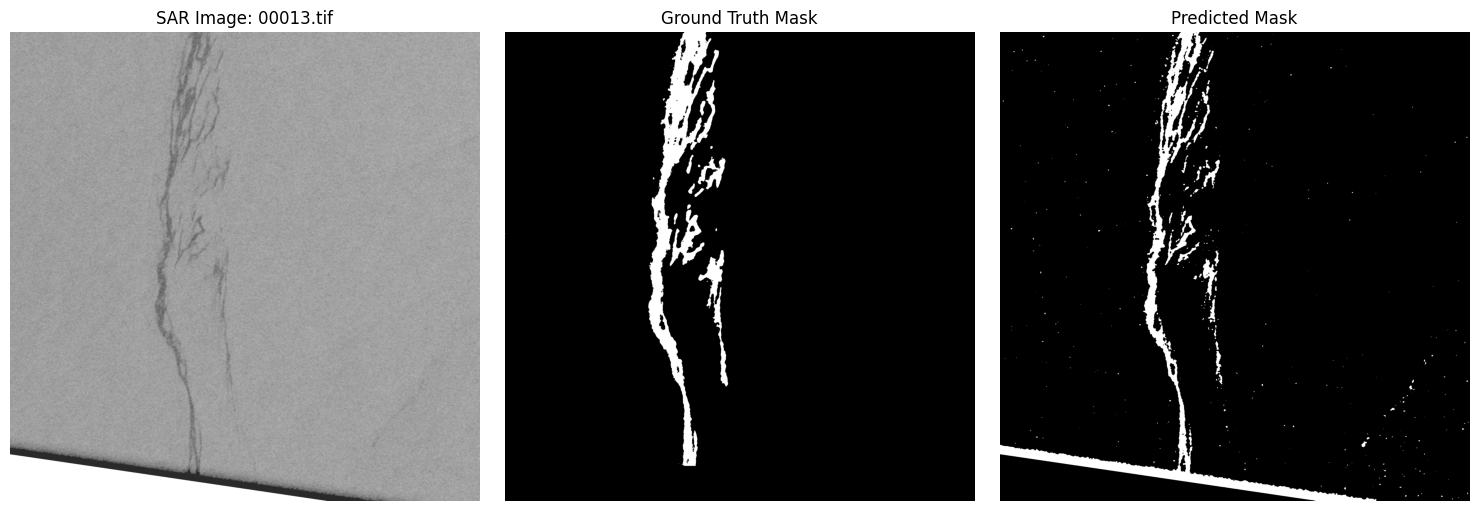

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00042.tif

Results for: 00042.tif


              precision    recall  f1-score   support

  Background       0.98      0.99      0.99   2858491
   Oil Spill       0.98      0.96      0.97   1335813

    accuracy                           0.98   4194304
   macro avg       0.98      0.97      0.98   4194304
weighted avg       0.98      0.98      0.98   4194304



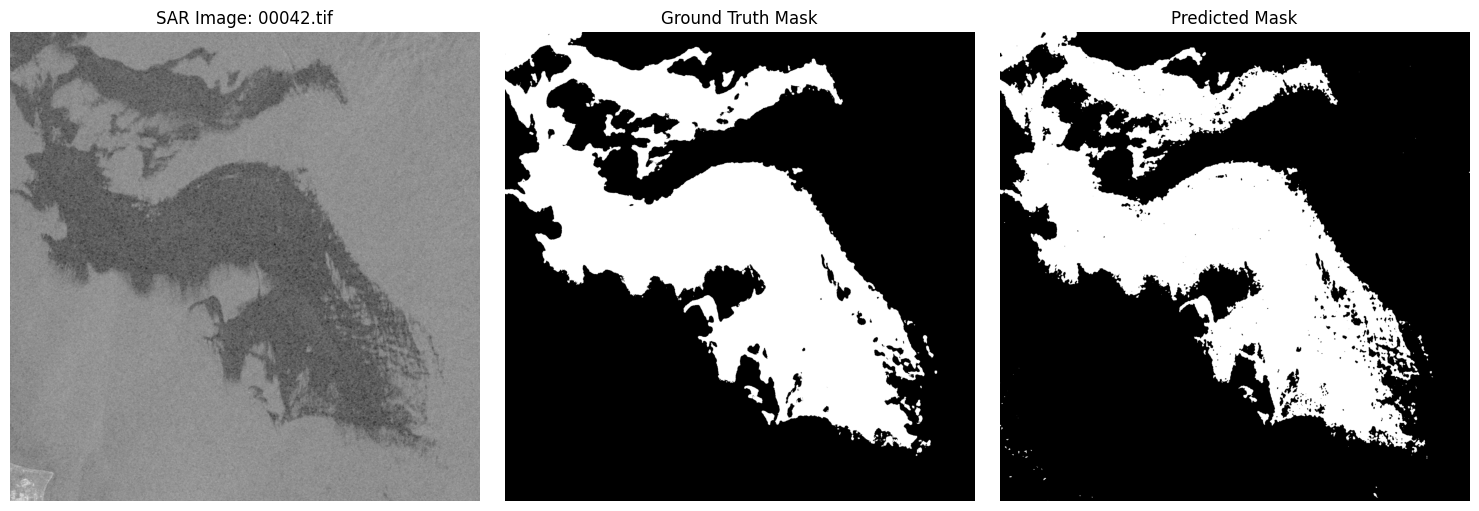

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00030.tif

Results for: 00030.tif


              precision    recall  f1-score   support

  Background       1.00      0.92      0.96   4179182
   Oil Spill       0.04      1.00      0.08     15122

    accuracy                           0.92   4194304
   macro avg       0.52      0.96      0.52   4194304
weighted avg       1.00      0.92      0.95   4194304



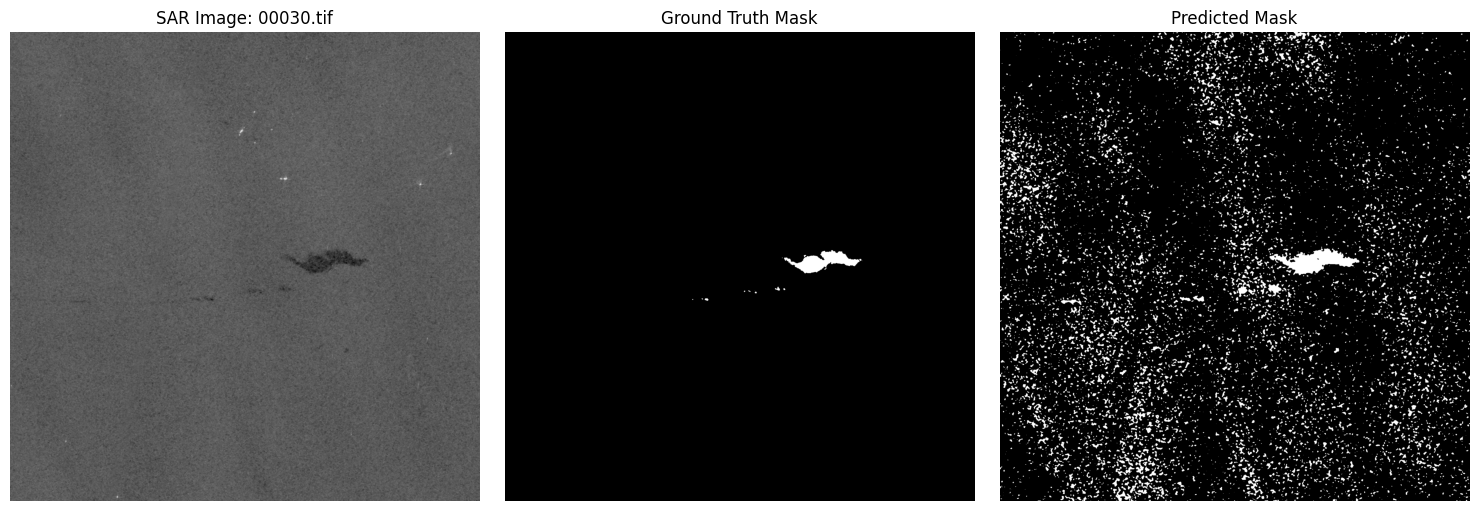

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00050.tif

Results for: 00050.tif


              precision    recall  f1-score   support

  Background       1.00      0.75      0.86   4056725
   Oil Spill       0.12      0.99      0.21    137579

    accuracy                           0.76   4194304
   macro avg       0.56      0.87      0.53   4194304
weighted avg       0.97      0.76      0.83   4194304



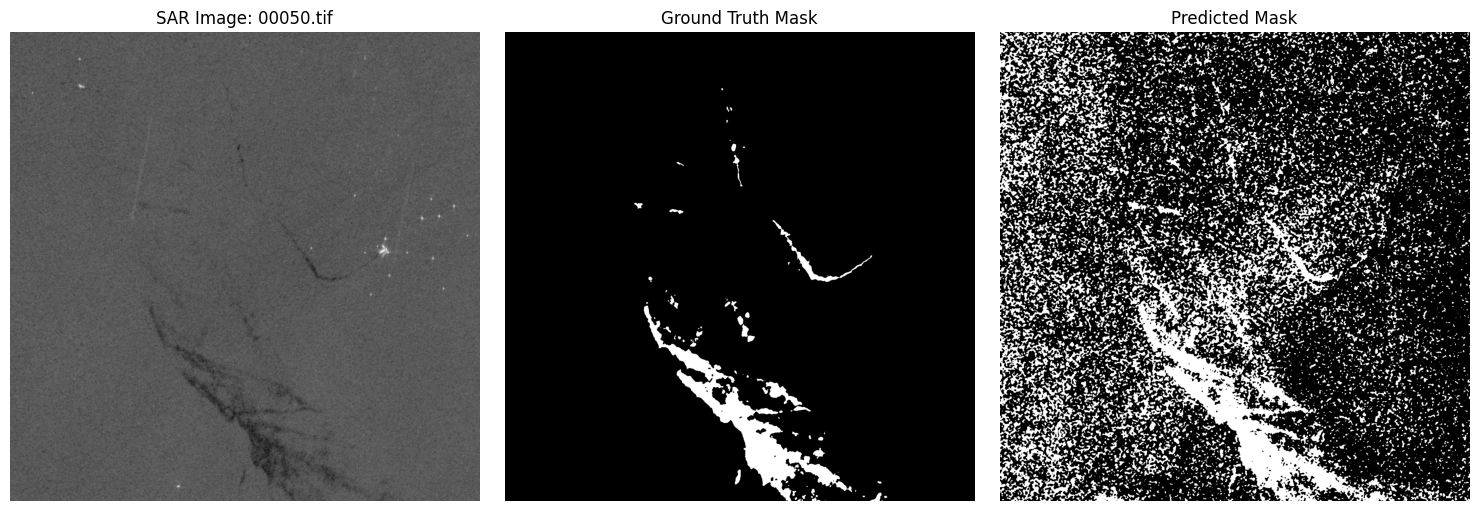

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00017.tif

Results for: 00017.tif


              precision    recall  f1-score   support

  Background       1.00      0.98      0.99   4108640
   Oil Spill       0.46      0.99      0.62     85664

    accuracy                           0.98   4194304
   macro avg       0.73      0.98      0.81   4194304
weighted avg       0.99      0.98      0.98   4194304



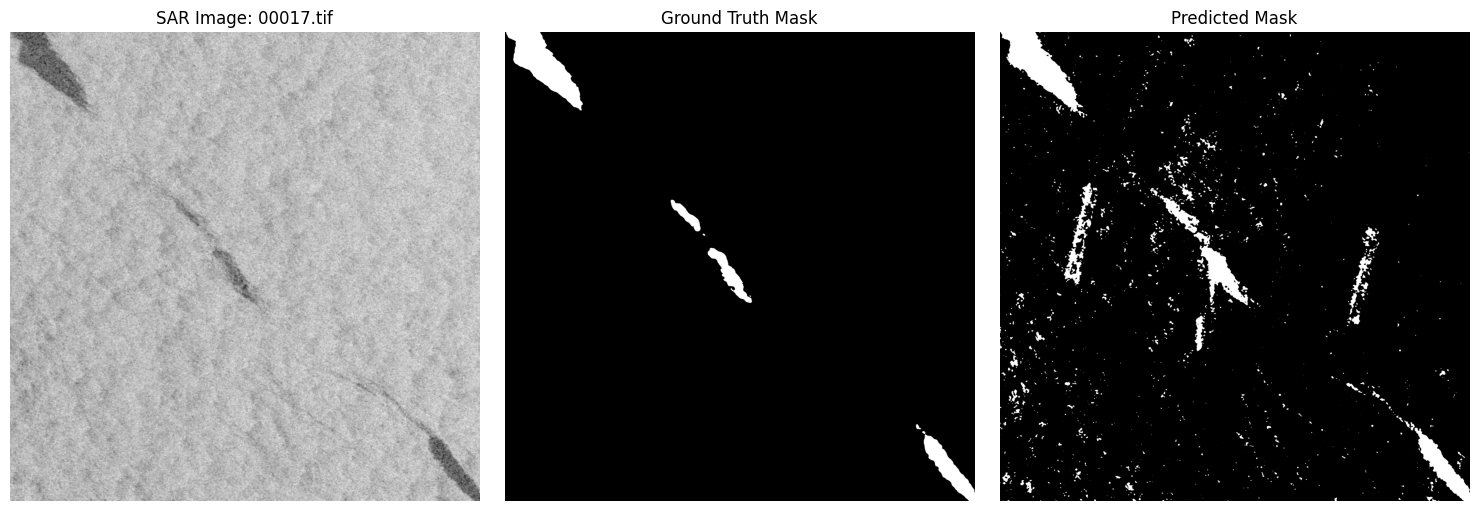

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00053.tif

Results for: 00053.tif


              precision    recall  f1-score   support

  Background       1.00      0.80      0.89   1787864
   Oil Spill       0.87      1.00      0.93   2406440

    accuracy                           0.91   4194304
   macro avg       0.93      0.90      0.91   4194304
weighted avg       0.92      0.91      0.91   4194304



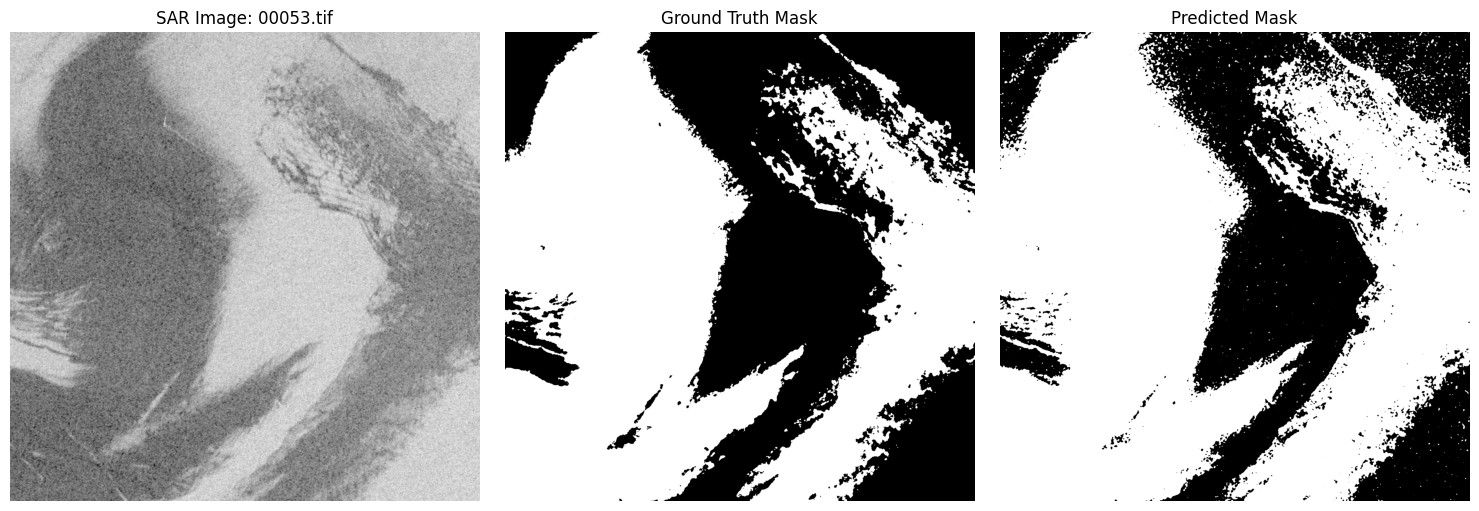

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00026.tif

Results for: 00026.tif


              precision    recall  f1-score   support

  Background       1.00      0.93      0.96   4045262
   Oil Spill       0.35      0.98      0.52    149042

    accuracy                           0.93   4194304
   macro avg       0.67      0.96      0.74   4194304
weighted avg       0.98      0.93      0.95   4194304



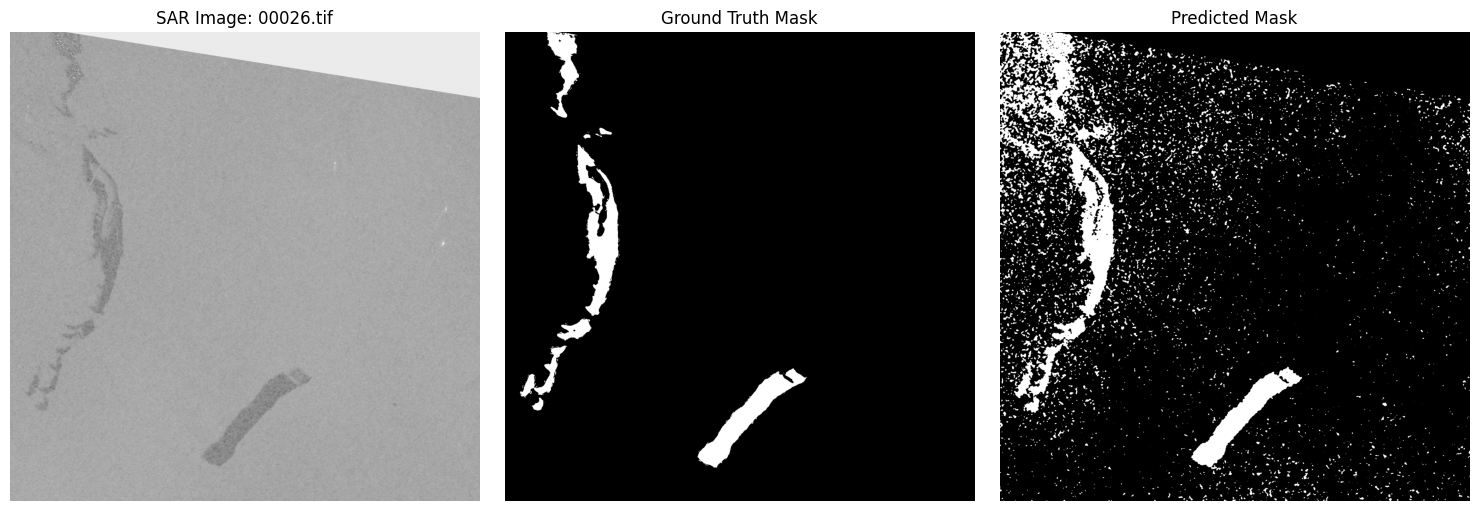

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00025.tif

Results for: 00025.tif


              precision    recall  f1-score   support

  Background       1.00      0.82      0.90   4092376
   Oil Spill       0.12      0.98      0.21    101928

    accuracy                           0.82   4194304
   macro avg       0.56      0.90      0.55   4194304
weighted avg       0.98      0.82      0.88   4194304



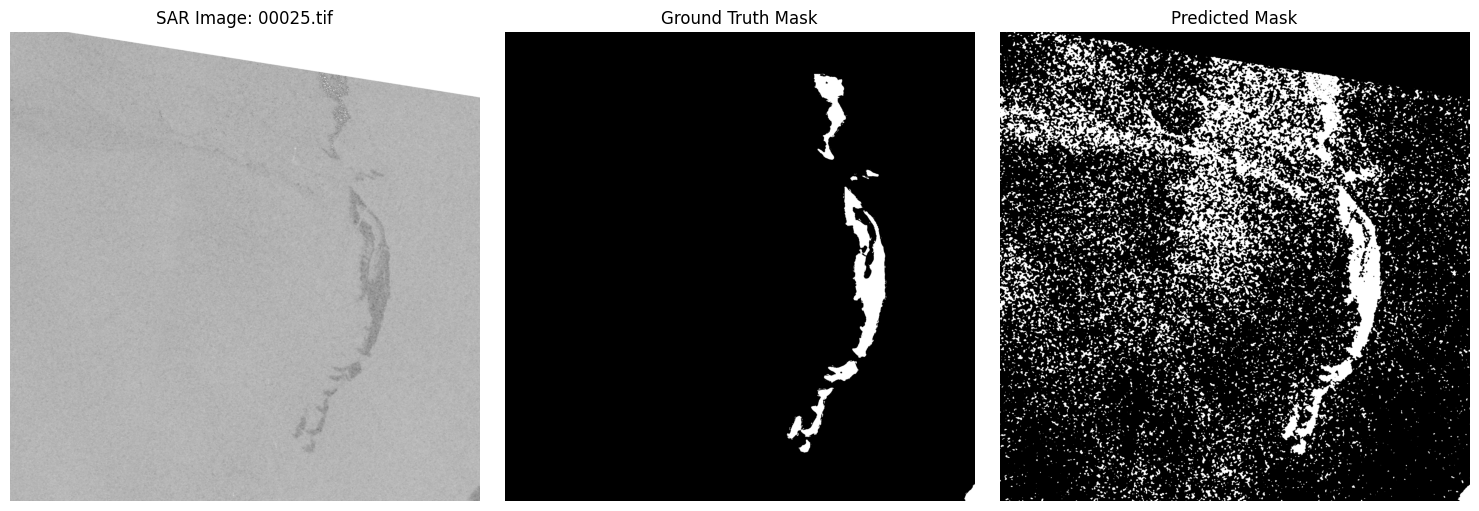

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00032.tif

Results for: 00032.tif


              precision    recall  f1-score   support

  Background       1.00      0.92      0.96   4181723
   Oil Spill       0.03      1.00      0.07     12581

    accuracy                           0.92   4194304
   macro avg       0.52      0.96      0.51   4194304
weighted avg       1.00      0.92      0.95   4194304



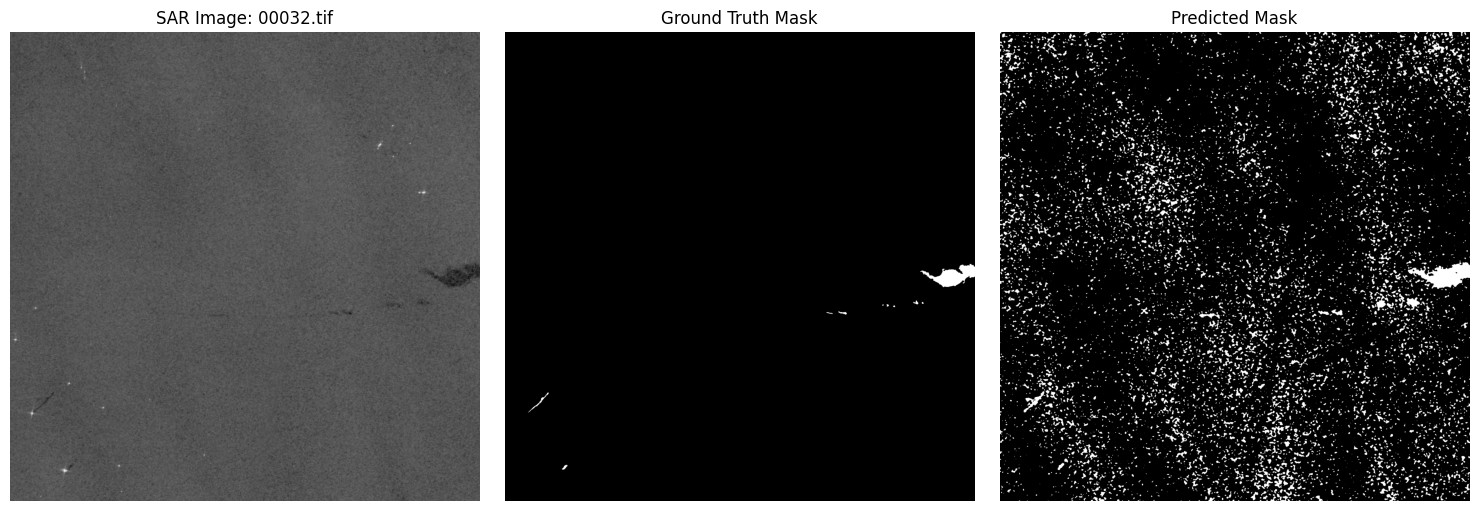

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00019.tif

Results for: 00019.tif


              precision    recall  f1-score   support

  Background       1.00      0.97      0.99   4105639
   Oil Spill       0.43      0.98      0.59     88665

    accuracy                           0.97   4194304
   macro avg       0.71      0.98      0.79   4194304
weighted avg       0.99      0.97      0.98   4194304



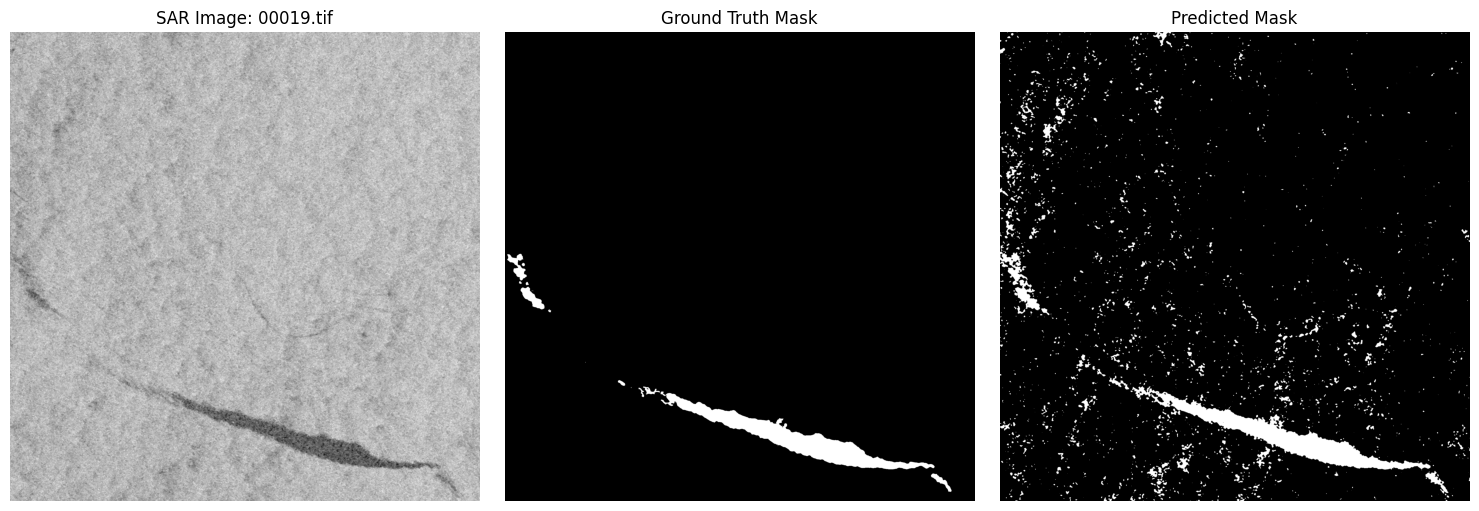

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00012.tif

Results for: 00012.tif


              precision    recall  f1-score   support

  Background       0.99      1.00      0.99   4026146
   Oil Spill       0.96      0.65      0.77    168158

    accuracy                           0.98   4194304
   macro avg       0.97      0.82      0.88   4194304
weighted avg       0.98      0.98      0.98   4194304



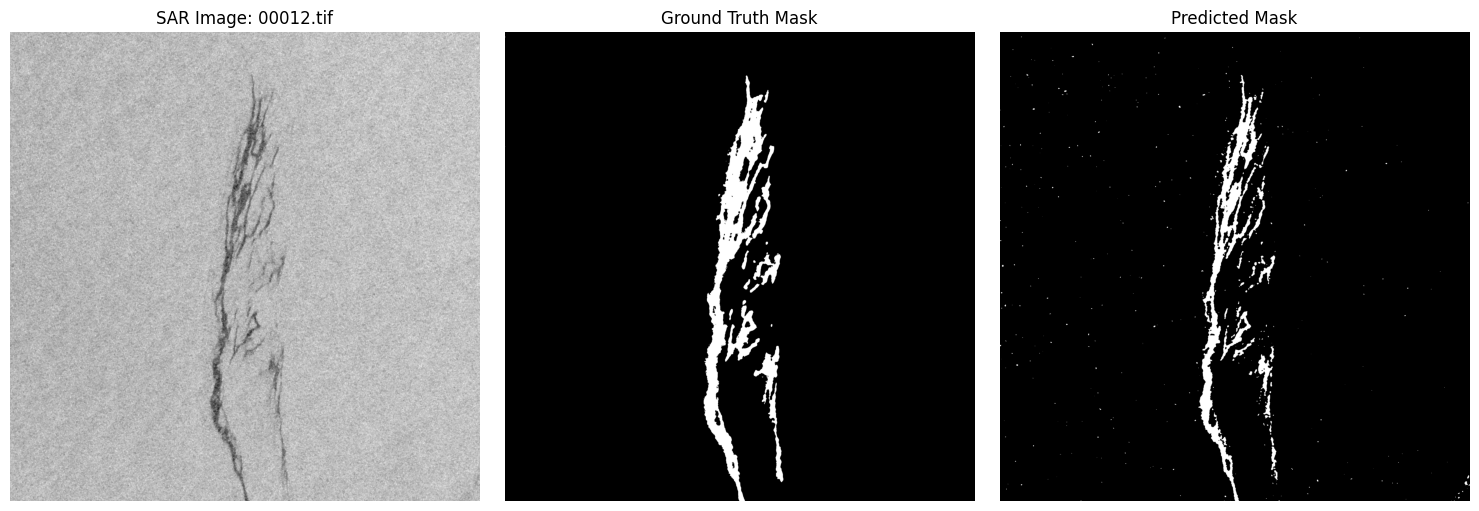

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00004.tif

Results for: 00004.tif


              precision    recall  f1-score   support

  Background       1.00      1.00      1.00   4150255
   Oil Spill       0.91      0.98      0.94     44049

    accuracy                           1.00   4194304
   macro avg       0.96      0.99      0.97   4194304
weighted avg       1.00      1.00      1.00   4194304



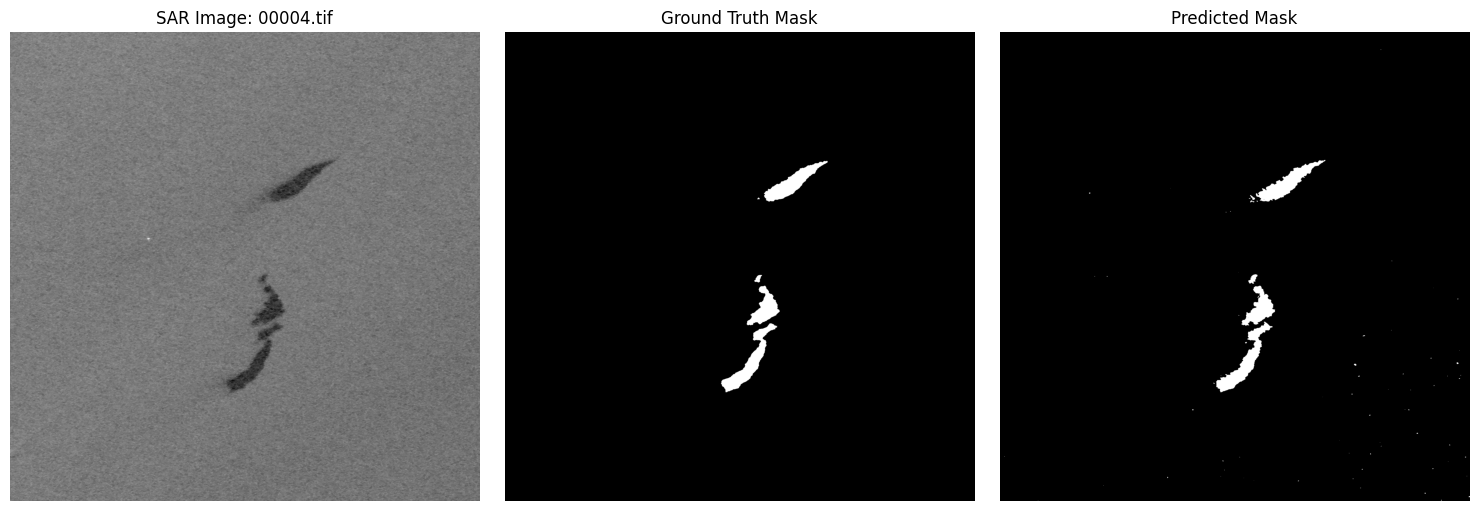

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00040.tif

Results for: 00040.tif


              precision    recall  f1-score   support

  Background       0.99      0.99      0.99   3093555
   Oil Spill       0.97      0.96      0.97   1100749

    accuracy                           0.98   4194304
   macro avg       0.98      0.97      0.98   4194304
weighted avg       0.98      0.98      0.98   4194304



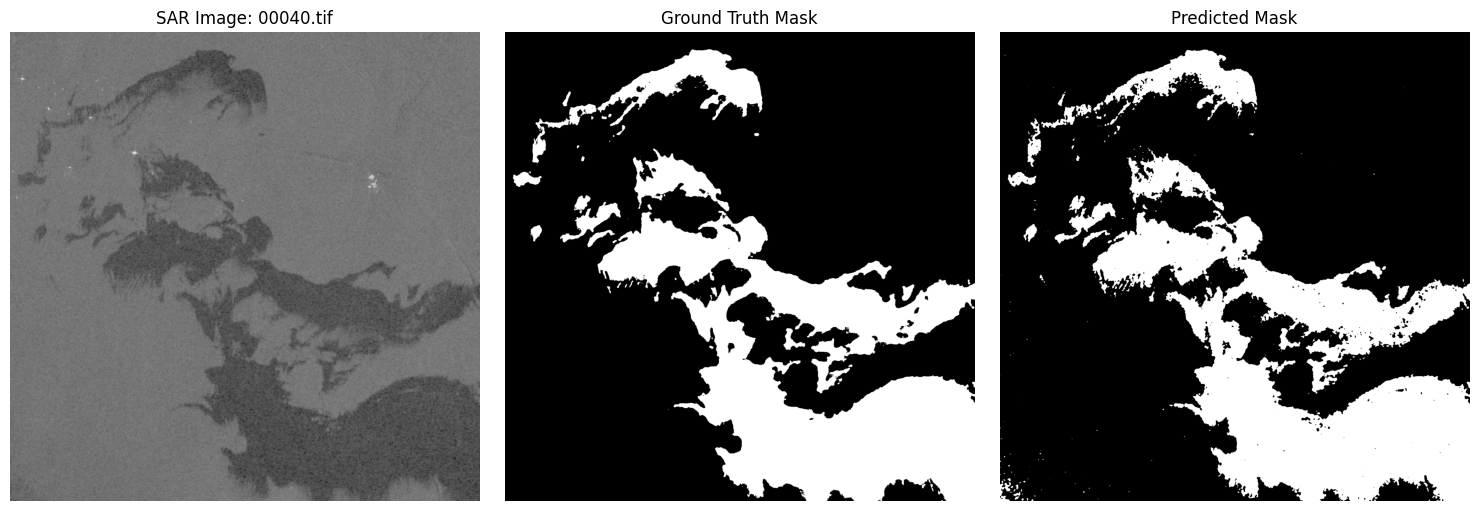

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00008.tif

Results for: 00008.tif


              precision    recall  f1-score   support

  Background       0.98      1.00      0.99   4093755
   Oil Spill       1.00      0.19      0.32    100549

    accuracy                           0.98   4194304
   macro avg       0.99      0.59      0.65   4194304
weighted avg       0.98      0.98      0.97   4194304



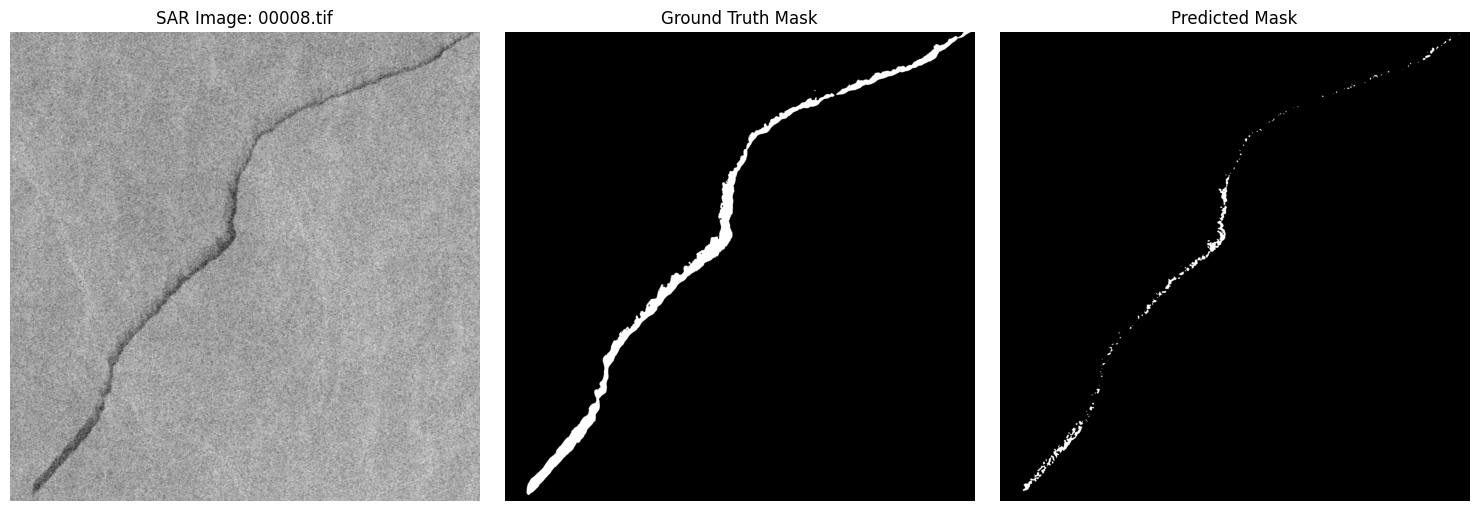

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Results for: 00003.tif

Results for: 00003.tif


              precision    recall  f1-score   support

  Background       1.00      1.00      1.00   4169513
   Oil Spill       0.85      0.98      0.91     24791

    accuracy                           1.00   4194304
   macro avg       0.93      0.99      0.95   4194304
weighted avg       1.00      1.00      1.00   4194304



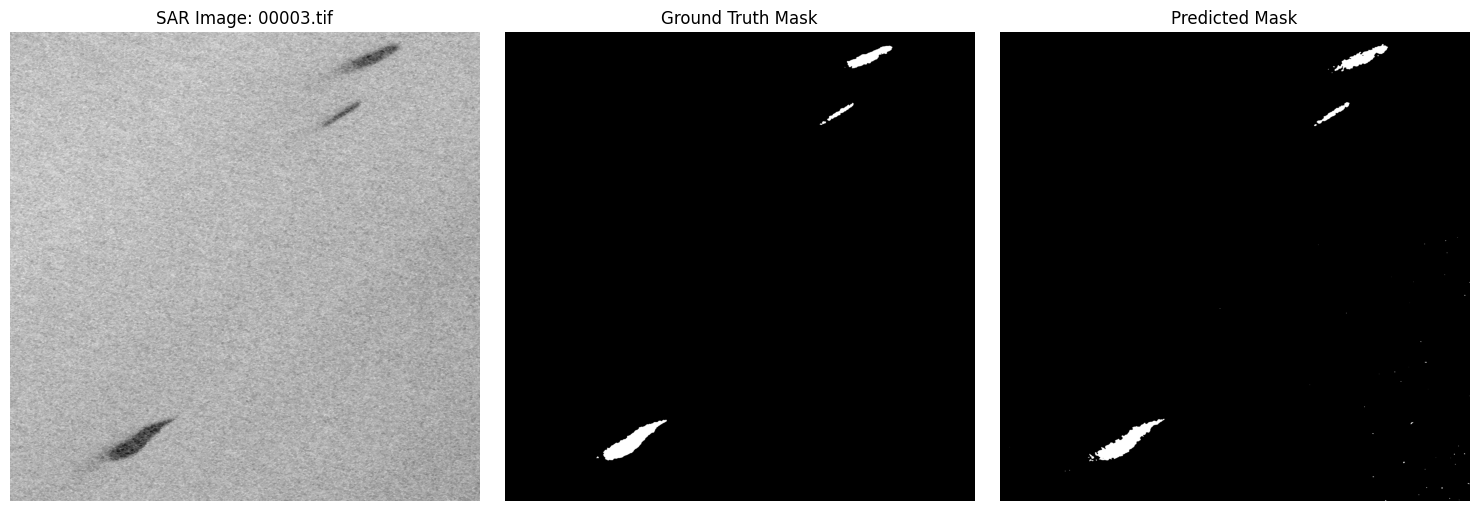

In [13]:
# Make predictions
for img_path, mask_path in zip(test_images, test_masks):

    X_test, Y_test = load_and_flatten(img_path, mask_path)
    y_pred = model.predict(X_test)

    print(f"\nResults for: {os.path.basename(img_path)}")
    print(f"\nResults for: {os.path.basename(mask_path)}")
    print(classification_report(Y_test, y_pred, target_names=["Background", "Oil Spill"]))


    with rasterio.open(img_path) as src:
        band1 = src.read(1)
        band2 = src.read(2)
        image_shape = band1.shape

    y_pred_image = y_pred.reshape(image_shape)
    y_true_image = Y_test.reshape(image_shape)

    # Visualize
    plt.figure(figsize=(15, 5))

    # SAR image for context (band2 looks better usually)
    plt.subplot(1, 3, 1)
    plt.title(f"SAR Image: {os.path.basename(img_path)}")
    plt.imshow(band2, cmap='gray')
    plt.axis('off')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(y_true_image, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(y_pred_image, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

    plt.tight_layout()
    plt.show()
